<a href="https://colab.research.google.com/github/ksy3432/ai-class-DL-Application-/blob/main/%5Blecture%5DDLA_week_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[지난 시간 복습]<br>
* cnn : local feature 고려
* rnn : (현재의 정보만을 반영->긴 시점 반영 불가) => 현재 정보 + 이전 상태의 정보
*LSTM : 이전 상태 + 현재 정보 + cell에 중요한 정보만 저장(중요한 정보는 장기기억, 아닌 건 단기기억)
* resnet : 잔차연결(skip-connection)=>(g.v.p 해결, 학습이 용이해진다)
* senet : se block 사용(fcnn이였던 것 같은데), 채널 별 중요도를 다르게 둔다(attention 개념으로 생각하면 된다(channel attention))
* inception : skip-conntection, 서로 다른 필터 사용, 차원 축소를 위해 1x1 mask 사용
* depthwise separable convolution(),pointwise separable convolution
* CBAM : 입력 피처 맵에서 중요한 정보를 강조하고 덜 중요한 정보를 억제(channel별로 attention)
* transformer(embedding(vector(one-hot보다 정보 차지량이 적다),positional(단어 순서 고려)),attention(self,multihead))
*AE : 차원 축소 및 latent vector얻기 위함(manifold learning),reconstruction error(주로 mse),
* 깃허브 정리 한 번 할 것

*(사캠 attention 함수의 종류 참조)dot attetion : Self-Attention을 효율적으로 계산하기 위한 방법
* batchnomalizaton : 각 층의 입력값을 정규화, 내부공변량 변화룰 방지
* attention => self,scaled-dot,cross,mask..
*transformer는 기본적으로 global 정보 추출 -> global을 추출한 영역에 cnn 적용(patch)
*induction bias(암묵적 가정,'이전 데이터가 있으면 반복될 것이다'라는 가정과 같음)-> 이걸 피하기 위해 transformer와 cnn 결합
*swin transformer
*AE
*linear,stack AE => encoder decoder 같음&대칭

실습 겸 과제
* non-linear AE(AE 비대칭하게 만들기)
* conv,LSTM 뒤에 붙이기(optional)
* denoising AE(noise 입력 후 타겟이 노이즈를 제거하도록 만들기)(마스크 활용) => 데이터 만들고 훈련/테스트 나눈 후 노이즈 추가. 이후 ae를 훈련하는데 target으로 원래의 train 사용
*DSA데이터 lying pedct(normal), sitting(abnormal)

In [1]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/DSA_features.csv')
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
df.isnull().value_counts()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,count
T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,T_yacc_std,T_yacc_skew,T_zacc_mean,T_zacc_max,T_zacc_min,T_zacc_var,T_zacc_std,T_zacc_skew,T_xgyro_mean,T_xgyro_max,T_xgyro_min,T_xgyro_var,T_xgyro_std,T_xgyro_skew,T_ygyro_mean,T_ygyro_max,T_ygyro_min,T_ygyro_var,T_ygyro_std,T_ygyro_skew,T_zgyro_mean,T_zgyro_max,T_zgyro_min,T_zgyro_var,T_zgyro_std,T_zgyro_skew,T_xmag_mean,T_xmag_max,T_xmag_min,T_xmag_var,T_xmag_std,T_xmag_skew,T_ymag_mean,T_ymag_max,T_ymag_min,T_ymag_var,T_ymag_std,T_ymag_skew,T_zmag_mean,T_zmag_max,T_zmag_min,T_zmag_var,T_zmag_std,T_zmag_skew,RA_xacc_mean,RA_xacc_max,RA_xacc_min,RA_xacc_var,RA_xacc_std,RA_xacc_skew,RA_yacc_mean,RA_yacc_max,RA_yacc_min,RA_yacc_var,RA_yacc_std,RA_yacc_skew,RA_zacc_mean,RA_zacc_max,RA_zacc_min,RA_zacc_var,RA_zacc_std,RA_zacc_skew,RA_xgyro_mean,RA_xgyro_max,RA_xgyro_min,RA_xgyro_var,RA_xgyro_std,RA_xgyro_skew,RA_ygyro_mean,RA_ygyro_max,RA_ygyro_min,RA_ygyro_var,RA_ygyro_std,RA_ygyro_skew,RA_zgyro_mean,RA_zgyro_max,RA_zgyro_min,RA_zgyro_var,RA_zgyro_std,RA_zgyro_skew,RA_xmag_mean,RA_xmag_max,RA_xmag_min,RA_xmag_var,RA_xmag_std,RA_xmag_skew,RA_ymag_mean,RA_ymag_max,RA_ymag_min,RA_ymag_var,RA_ymag_std,RA_ymag_skew,RA_zmag_mean,RA_zmag_max,RA_zmag_min,RA_zmag_var,RA_zmag_std,RA_zmag_skew,LA_xacc_mean,LA_xacc_max,LA_xacc_min,LA_xacc_var,LA_xacc_std,LA_xacc_skew,LA_yacc_mean,LA_yacc_max,LA_yacc_min,LA_yacc_var,LA_yacc_std,LA_yacc_skew,LA_zacc_mean,LA_zacc_max,LA_zacc_min,LA_zacc_var,LA_zacc_std,LA_zacc_skew,LA_xgyro_mean,LA_xgyro_max,LA_xgyro_min,LA_xgyro_var,LA_xgyro_std,LA_xgyro_skew,LA_ygyro_mean,LA_ygyro_max,LA_ygyro_min,LA_ygyro_var,LA_ygyro_std,LA_ygyro_skew,LA_zgyro_mean,LA_zgyro_max,LA_zgyro_min,LA_zgyro_var,LA_zgyro_std,LA_zgyro_skew,LA_xmag_mean,LA_xmag_max,LA_xmag_min,LA_xmag_var,LA_xmag_std,LA_xmag_skew,LA_ymag_mean,LA_ymag_max,LA_ymag_min,LA_ymag_var,LA_ymag_std,LA_ymag_skew,LA_zmag_mean,LA_zmag_max,LA_zmag_min,LA_zmag_var,LA_zmag_std,LA_zmag_skew,RL_xacc_mean,RL_xacc_max,RL_xacc_min,RL_xacc_var,RL_xacc_std,RL_xacc_skew,RL_yacc_mean,RL_yacc_max,RL_yacc_min,RL_yacc_var,RL_yacc_std,RL_yacc_skew,RL_zacc_mean,RL_zacc_max,RL_zacc_min,RL_zacc_var,RL_zacc_std,RL_zacc_skew,RL_xgyro_mean,RL_xgyro_max,RL_xgyro_min,RL_xgyro_var,RL_xgyro_std,RL_xgyro_skew,RL_ygyro_mean,RL_ygyro_max,RL_ygyro_min,RL_ygyro_var,RL_ygyro_std,RL_ygyro_skew,RL_zgyro_mean,RL_zgyro_max,RL_zgyro_min,RL_zgyro_var,RL_zgyro_std,RL_zgyro_skew,RL_xmag_mean,RL_xmag_max,RL_xmag_min,RL_xmag_var,RL_xmag_std,RL_xmag_skew,RL_ymag_mean,RL_ymag_max,RL_ymag_min,RL_ymag_var,RL_ymag_std,RL_ymag_skew,RL_zmag_mean,RL_zmag_max,RL_zmag_min,RL_zmag_var,RL_zmag_std,RL_zmag_skew,LL_xacc_mean,LL_xacc_max,LL_xacc_min,LL_xacc_var,LL_xacc_std,LL_xacc_skew,LL_yacc_mean,LL_yacc_max,LL_yacc_min,LL_yacc_var,LL_yacc_std,LL_yacc_skew,LL_zacc_mean,LL_zacc_max,LL_zacc_min,LL_zacc_var,LL_zacc_std,LL_zacc_skew,LL_xgyro_mean,LL_xgyro_max,LL_xgyro_min,LL_xgyro_var,LL_xgyro_std,LL_xgyro_skew,LL_ygyro_mean,LL_ygyro_max,LL_ygyro_min,LL_ygyro_var,LL_ygyro_std,LL_ygyro_skew,LL_zgyro_mean,LL_zgyro_max,LL_zgyro_min,LL_zgyro_var,LL_zgyro_std,LL_zgyro_skew,LL_xmag_mean,LL_xmag_max,LL_xmag_min,LL_xmag_var,LL_xmag_std,LL_xmag_skew,LL_ymag_mean,LL_ymag_max,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people,
False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [4]:
df['activity'].value_counts()

,count
activity,
sitting,480
walkingTreadmillIncline,480
jumping,480
rowing,480
cyclingVertical,480
cyclingHorizontal,480
crossTrainer,480
stepper,480
runningTreadmill,480


In [5]:
df['people'] = df['people'].replace({'p1': '0','p2' : '1','p3': '2','p4' : '3','p5': '4','p6' : '5','p7': '6','p8' : '7'})

In [6]:
normal = df[(df['activity'] == 'lyingRigh') | (df['activity'] == 'lyingBack')]
normal['activity'] = normal['activity'].replace({'lyingRigh': 'lying','lyingBack' : 'lying'})
abnormal = df[df['activity'] == 'sitting']
print(normal)
print(abnormal)
print(normal.shape)
print(abnormal.shape)

      T_xacc_mean  T_xacc_max  T_xacc_min  T_xacc_var  T_xacc_std  \
960     -4.834646     -4.7185     -4.9049    0.001124    0.033529   
961     -4.780810     -4.5850     -4.8833    0.003948    0.062835   
962     -4.804400     -4.7037     -4.8755    0.001482    0.038496   
963     -4.750563     -4.5696     -4.8977    0.004447    0.066683   
964     -4.774916     -4.6741     -4.8457    0.001080    0.032868   
...           ...         ...         ...         ...         ...   
1915     2.620502      2.6592      2.5891    0.000199    0.014113   
1916     2.613423      2.6572      2.5815    0.000207    0.014387   
1917     2.614750      2.6576      2.5654    0.000257    0.016018   
1918     2.620167      2.6589      2.5781    0.000216    0.014691   
1919     2.615565      2.6789      2.5734    0.000310    0.017610   

      T_xacc_skew  T_yacc_mean  T_yacc_max  T_yacc_min  T_yacc_var  ...  \
960      0.632141    -0.501018    -0.41744    -0.59561    0.001016  ...   
961      1.052880    

<ipython-input-6-d41a9cf8a517>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal['activity'] = normal['activity'].replace({'lyingRigh': 'lying','lyingBack' : 'lying'})


In [7]:
normal['people'] = normal['people'].astype('float64')
abnormal['people'] =abnormal['people'].astype('float64')

<ipython-input-7-072e3e7f8fd3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal['people'] = normal['people'].astype('float64')
<ipython-input-7-072e3e7f8fd3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abnormal['people'] =abnormal['people'].astype('float64')


In [8]:
normal.dtypes

,0
T_xacc_mean,float64
T_xacc_max,float64
T_xacc_min,float64
T_xacc_var,float64
T_xacc_std,float64
...,...
LL_zmag_var,float64
LL_zmag_std,float64
LL_zmag_skew,float64
activity,object


In [9]:
X = normal.drop('activity',axis=1)
y = normal['activity']
ab_X = abnormal.drop('activity',axis=1)
ab_y = abnormal['activity']

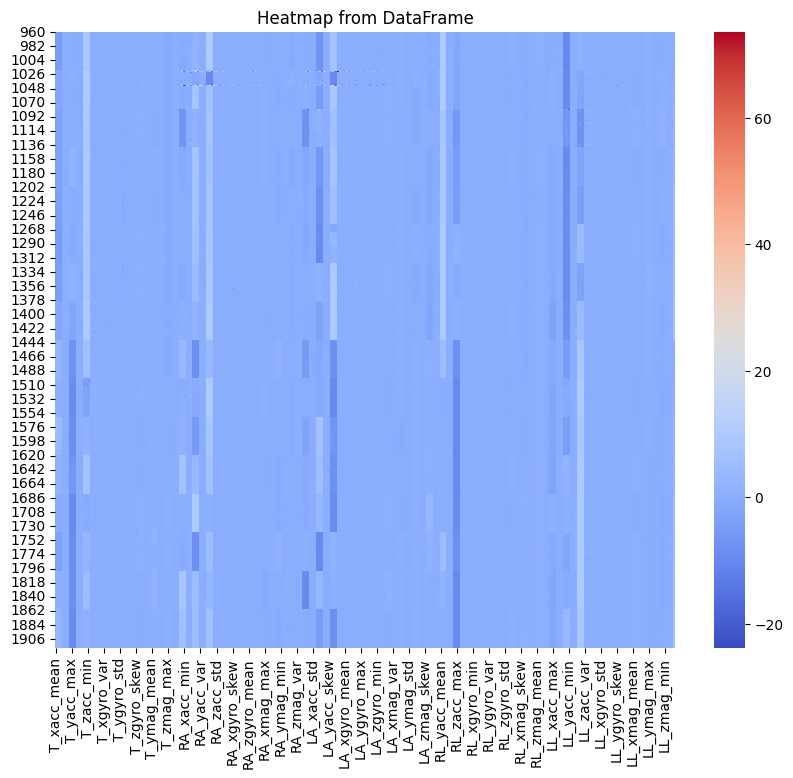

In [10]:
import seaborn as sns
# 히트맵 그리기
plt.figure(figsize=(10, 8))
normal_check = normal.drop('activity',axis=1)
sns.heatmap(normal_check, annot=False, cmap='coolwarm')
plt.title('Heatmap from DataFrame')
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 1262 to 1062
Columns: 271 entries, T_xacc_mean to people
dtypes: float64(271)
memory usage: 1.6 MB


In [13]:
X_train.dtypes

,0
T_xacc_mean,float64
T_xacc_max,float64
T_xacc_min,float64
T_xacc_var,float64
T_xacc_std,float64
...,...
LL_zmag_min,float64
LL_zmag_var,float64
LL_zmag_std,float64
LL_zmag_skew,float64


In [14]:
No_noise_train = X_train.copy()

noise_factor = 0.5

for label in X_train.columns:
  num = X_train[label].shape[0]
  X_train[label] = pd.to_numeric(X_train[label], errors='coerce')
  X_train[label] = X_train[label] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=num)

In [15]:
No_noise_train

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,people
1262,-4.541241,-4.44020,-4.63410,0.001340,0.036602,0.017044,-0.900889,-0.82668,-1.01970,0.001715,...,5.031118e-07,0.000709,0.006901,-0.653858,-0.65199,-0.65580,5.322756e-07,0.000730,0.025929,5.0
1427,-1.668885,-1.61860,-1.71250,0.000510,0.022587,0.174769,-2.259705,-2.14930,-2.33960,0.000994,...,7.335241e-05,0.008565,0.337140,-0.637659,-0.61554,-0.66108,6.682249e-05,0.008175,-0.090984,7.0
1254,-3.821946,-3.69680,-3.93580,0.002595,0.050945,-0.383433,-0.491602,-0.42581,-0.54426,0.000504,...,4.653010e-07,0.000682,-0.260774,0.635377,0.63723,0.63401,4.532566e-07,0.000673,0.036905,4.0
1508,0.454222,0.49106,0.41591,0.000306,0.017496,-0.300751,-8.862662,-8.79640,-8.93040,0.000805,...,4.248145e-06,0.002061,-0.325501,-0.894958,-0.89257,-0.89746,7.151732e-07,0.000846,-0.093956,1.0
1425,-1.656930,-1.60300,-1.72510,0.000895,0.029912,-0.246805,-2.278474,-2.23090,-2.35270,0.000611,...,6.072402e-05,0.007793,0.862603,-0.637034,-0.61364,-0.66625,7.641000e-05,0.008741,0.049122,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,-2.077746,-1.99330,-2.17230,0.001209,0.034776,-0.313388,-0.469514,-0.38469,-0.66033,0.002111,...,4.388285e-07,0.000662,-0.394638,0.315758,0.31735,0.31360,4.394426e-07,0.000663,-0.170766,1.0
1230,-3.830510,-3.71190,-3.98720,0.005074,0.071235,-0.620722,-0.505787,-0.43961,-0.60264,0.000687,...,6.125316e-07,0.000783,0.165551,0.634941,0.63684,0.63337,5.346971e-07,0.000731,0.388538,4.0
1820,0.475771,0.54707,0.39811,0.000648,0.025451,0.296898,-8.565474,-8.49370,-8.66360,0.001218,...,6.179644e-07,0.000786,0.055165,-0.857231,-0.85580,-0.85905,5.081913e-07,0.000713,-0.314481,6.0
1395,-1.690450,-1.64210,-1.75840,0.000639,0.025276,-0.236978,-2.291043,-2.24090,-2.33680,0.000487,...,5.240129e-05,0.007239,0.393974,-0.628978,-0.59942,-0.65374,8.187129e-05,0.009048,0.375780,7.0


In [16]:
No_noise_test = X_test.copy()

noise_factor = 0.5

for label in X_test.columns:
  num = X_test[label].shape[0]
  X_test[label] = pd.to_numeric(X_test[label], errors='coerce')
  X_test[label] = X_test[label] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=num)

In [17]:
input_dim = X_train.shape[1]
encoding_dim = 14  # 인코딩 차원을 설정 (임의로 설정한 값, 조정 가능)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
encoded = Dense(int(encoding_dim / 4), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 4), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [18]:
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data =(No_noise_train,No_noise_train))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 402ms/step - loss: 6.0057 - val_loss: 5.7812
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 6.0140 - val_loss: 5.7772
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 6.0067 - val_loss: 5.7714
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 5.9884 - val_loss: 5.7640
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 6.0373 - val_loss: 5.7544
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 6.0244 - val_loss: 5.7421
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 6.0099 - val_loss: 5.7271
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 6.0293 - val_loss: 5.7085
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 5.9434 - val_loss: 5.6860
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.9492 - val_loss: 5.6598
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.9206 - val_loss: 5.6295
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.8293 - val_loss: 5.5954


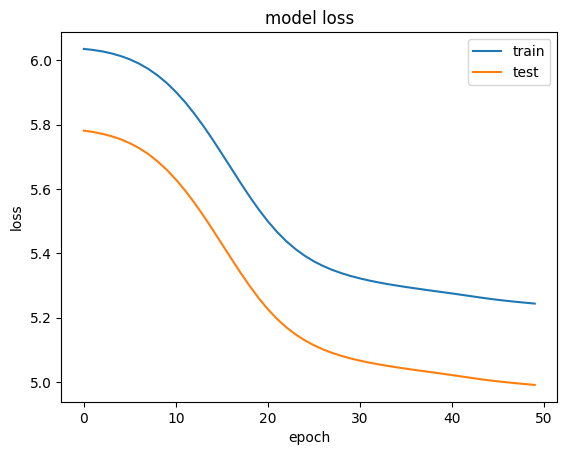

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [20]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


,reconstruction_error
count,192.000000
mean,5.209287
std,0.333262
min,4.665568
25%,4.998139
50%,5.156850
75%,5.339545
max,7.077110
